### Import Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import hydra
from hydra import initialize, compose

import torch
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelSummary, ModelCheckpoint

In [3]:
from src.models.vae import VAE
from src.data.vae_data import CifarDataModule
from src.utils.vae_transforms import image_transforms
from src.utils.initialize import create_dirs
from src.utils.plotting import plot_vae_samples, plot_vae_results

/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contra

### Load Config

In [4]:
try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")


In [5]:
cfg = compose(config_name="config")

### Create Required Directories

In [6]:
create_dirs(
    [
        cfg.root.data_path,
        cfg.root.models,
        cfg.root.logs,
        cfg.vae.data.cifar,
        cfg.vae.models,
        cfg.vae.logs,
    ],
    ".",
)


### Load the Data

In [7]:
datamodule = CifarDataModule(
    path=cfg.vae.data.cifar,
    transforms=image_transforms,
    num_classes=10,
    batch_size=cfg.vae.batch_size,
)
datamodule.setup()


Files already downloaded and verified
Files already downloaded and verified


### Plot Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


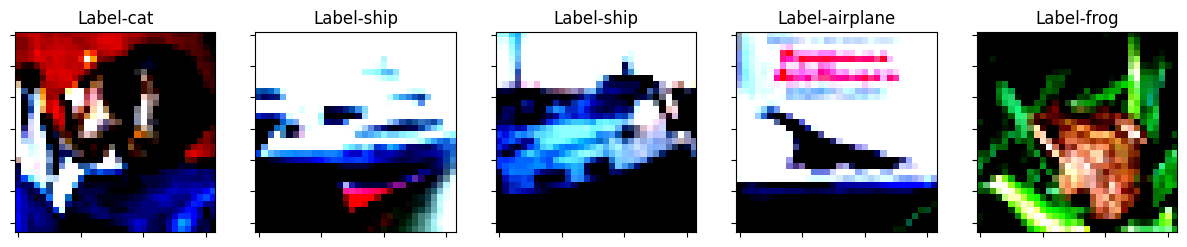

In [8]:
plot_vae_samples(datamodule=datamodule,
                 class_map=datamodule.train_dataset.data.classes,
                 num_images=5)

### Loading the Model

In [9]:
model = VAE(
    enc_out_dim=512,
    latent_dim=256,
    input_height=32,
    num_class=10
)

/home/ravi.naik/learning/era/s18/src/models/vae.py:18: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/home/ravi.naik/miniconda3/envs/torchenv/lib/

In [10]:
callbacks = [
    ModelSummary(max_depth=3),
    ModelCheckpoint(
        dirpath=f"{cfg.vae.models}/vae_cifar",
        filename="tr_{epoch}",
        monitor="kl",
        mode="min",
        save_last=True,
    ),
]


In [11]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    num_nodes=1,
    max_epochs=cfg.vae.epochs,
    callbacks=callbacks
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train Model

In [12]:
trainer.fit(model=model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name             | Type              | Params
--------------------------------------------------------
0  | encoder          | ResNetEncoder     | 11.2 M
1  | encoder.conv1    | Conv2d            | 1.7 K 
2  | encoder.bn1      | BatchNorm2d       | 128   
3  | encoder.relu     | ReLU              | 0     
4  | encoder.maxpool  | MaxPool2d         | 0     
5  | encoder.layer1   | Sequential        | 147 K 
6  | encoder.layer1.0 | EncoderBlock      | 74.0 K
7  | encoder.layer1.1 | EncoderBlock      | 74.0 K
8  | encoder.layer2   | Sequential        | 525 K 
9  | encoder.layer2.0 | EncoderBlock      | 230 K 
10 | encoder.layer2.1 | EncoderBlock      | 295 K 
11 | encoder.layer3   | Sequential        | 2.1 M 
12 | encoder.layer3.0 | EncoderBlock      | 919 K 
13 | encoder.layer3.1 | EncoderBlock      | 1.2 M 
14 | encoder.layer4   | Sequential        | 8.4 M 
15 | encoder.layer4.0 | EncoderBlock      | 3.7 M 
16 | encoder.layer4.1 | Encoder

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### Check Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

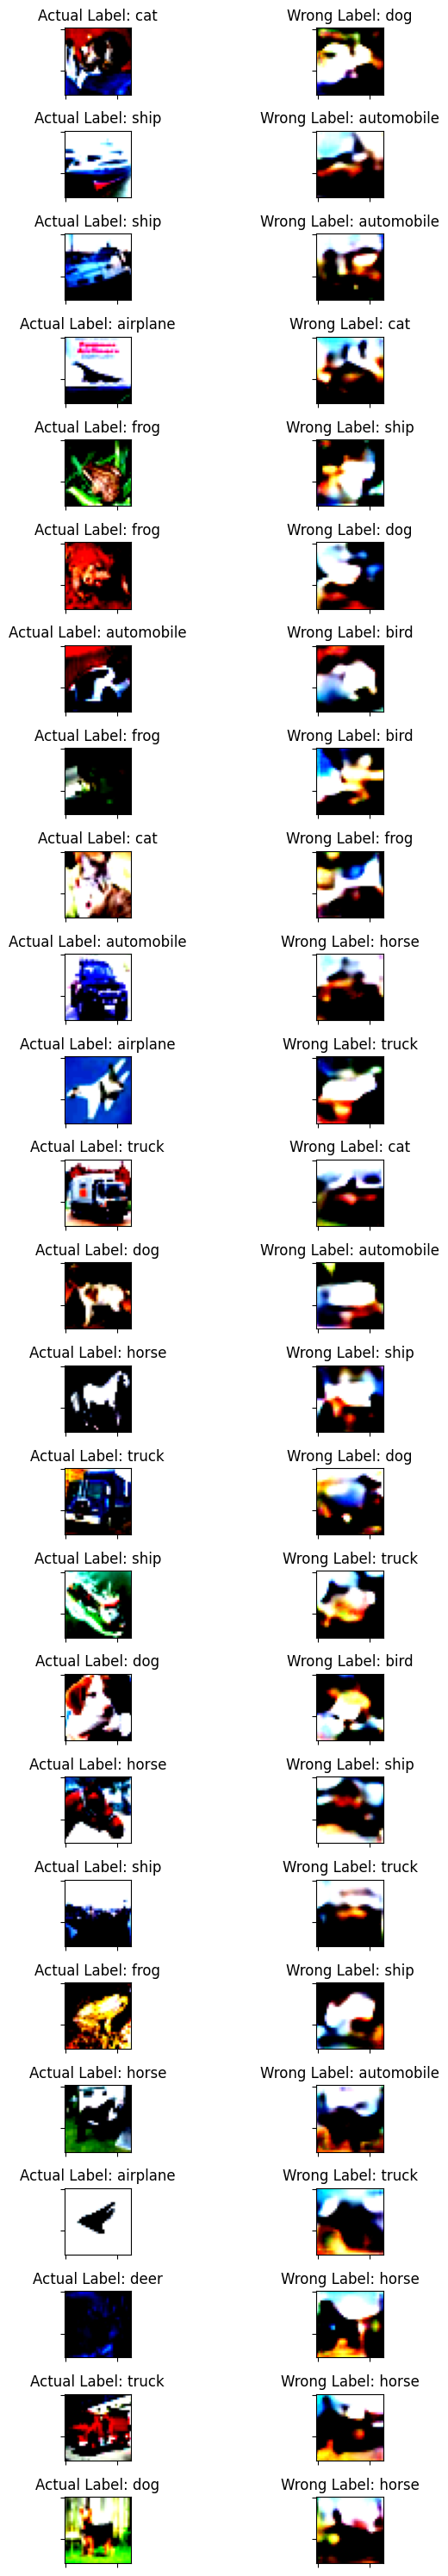

In [13]:
plot_vae_results(model=model, datamodule=datamodule,
                 class_map=datamodule.train_dataset.data.classes,
                 num_images=25,
                 num_classes=10)
